# Node Classification - MAG
## Experiment results

In [ ]:
import comet_ml
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import auc
import pandas as pd

sns.set_style('white')

In [ ]:
models = ['gcn', 'sage', 'gin']
types = ['base', 'transfer', 'self-transfer', 'self-transfer-new-layer']

***
### Gathering results
Run the cell below to gather all the experiment results from  Comet.ml.

In [ ]:
comet_api = comet_ml.api.API()
experiments = comet_api.get('graph-net-experiments/node-classification')

# gets dict with experiment_id : set of tags
experiments_with_tags = {
    exp.id: frozenset(exp.get_tags())
    for exp in experiments
}

tags = set(experiments_with_tags.values()) # gets unique tags
experiments_by_tags = { tag: [] for tag in tags } 

# experiments_by_tags: dict with all experiment ids under unique tags
for exp, exp_tags in experiments_with_tags.items():
    experiments_by_tags[exp_tags].append(exp)

experiment_results = { tag: '💩' for tag in tags }  # 💩 emoji will be replaced with exp. results

print('Gathering experiment results')
print('----------------------------')

for exp_model in models:
    print(exp_model + '...')

    for exp_type in types:
        print('    ' + exp_type)
        exp_tag = frozenset({exp_model, exp_type})

        losses = []
        accuracies = []

        for exp_id in experiments_by_tags[exp_tag]:
            loss = np.array([  float(step['metricValue'])
                            for step in comet_api.get_experiment_by_id(exp_id).get_metrics('train_loss')])
            acc   = np.array([  float(step['metricValue']) 
                            for step in comet_api.get_experiment_by_id(exp_id).get_metrics('accuracy')])
            
            # insert nan at end when short of one value
            if len(loss) == 1999: 
                loss = np.hstack( (loss, np.nan) )
            if len(acc) == 1999: 
                acc = np.hstack( (acc, np.nan) )

            losses.append(loss)
            accuracies.append(acc)
            
        losses = np.stack(losses)
        accuracies = np.stack(accuracies)

        experiment_results[exp_tag] = {
            'losses': losses,
            'accuracies': accuracies
        }

Gathering experiment results
----------------------------
gcn...
    base
    transfer
    self-transfer
    self-transfer-new-layer
sage...
    base
    transfer
    self-transfer
    self-transfer-new-layer
gin...
    base
    transfer
    self-transfer
    self-transfer-new-layer


In [ ]:
torch.save(experiment_results, 'experiment_result_dict')

### Plotting results
Alternatively, use saved results from `experiment_result_dict`.

In [ ]:
experiment_results = torch.load('experiment_result_dict')

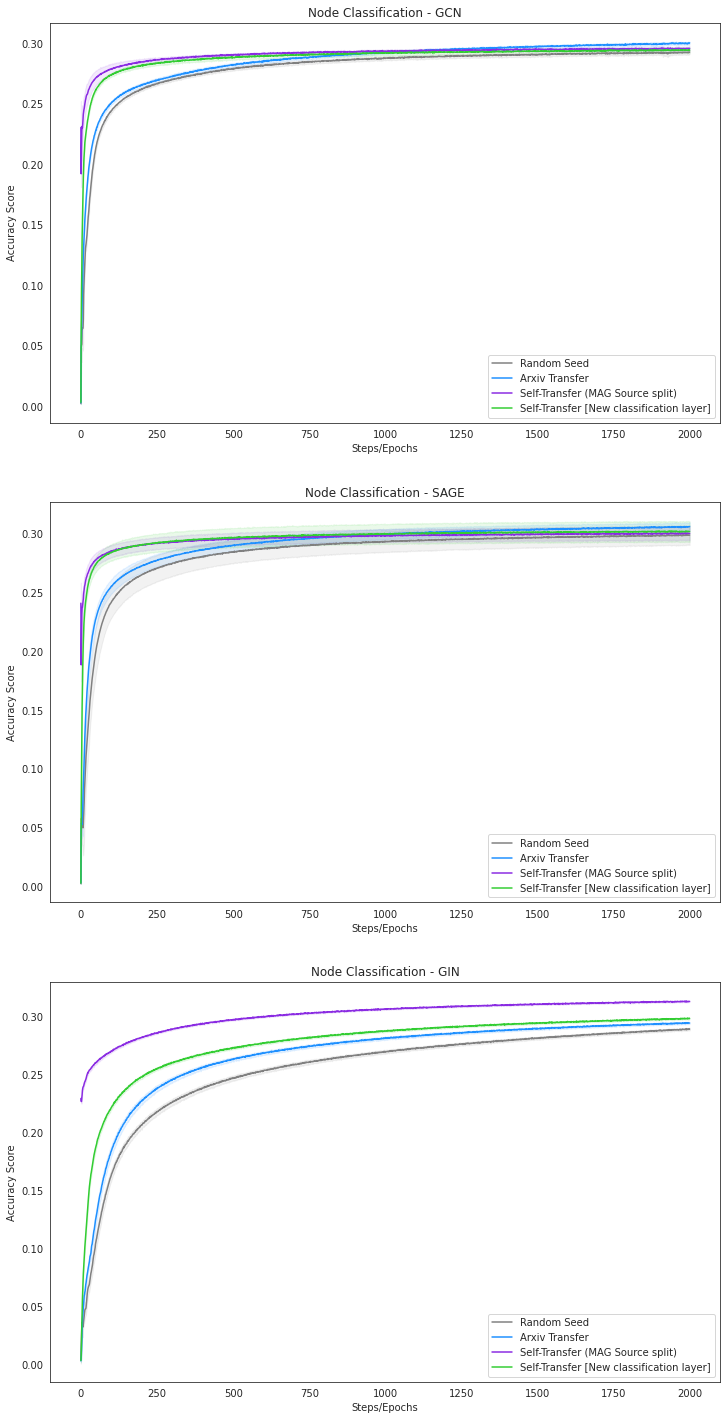

In [ ]:
legend_dict = {
    'base': 'Random Seed',
    'transfer': 'Arxiv Transfer',
    'self-transfer': 'Self-Transfer (MAG Source split)',
    'self-transfer-new-layer': 'Self-Transfer [New classification layer]'}
colours = {'base': 'grey', 'transfer': 'dodgerblue', 'self-transfer': 'blueviolet', 'self-transfer-new-layer': 'limegreen',}

plt.figure(figsize=(12, 25))

for i, model in enumerate(models):
    plt.subplot(3,1,i+1)

    for type_ in types:
        acc = experiment_results[frozenset({model, type_})]['accuracies']
        acc_mean = acc.mean(axis=0)
        acc_std = (acc_mean + acc.std(axis=0), acc_mean - acc.std(axis=0))

        plt.plot(acc.mean(axis=0), label=legend_dict[type_], color=colours[type_])
        plt.fill_between(np.arange(len(acc_mean)), acc_std[0], acc_std[1], alpha=0.1, color=colours[type_])
    
    plt.xlabel('Steps/Epochs')
    plt.ylabel('Accuracy Score')
    plt.title('Node Classification - ' + model.upper())
    plt.legend()

#### Transfer ratio

In [ ]:
def transfer_ratio(base_curve, transfer_curve):
    base_auc = auc(np.arange(2000), base_curve)
    transfer_auc = auc(np.arange(2000), transfer_curve)

    return (transfer_auc - base_auc) / base_auc


def get_exp_transfer_ratios(base_curve, transfer_curve):
    return np.array([ transfer_ratio(b, t) for b, t in zip(base_curve, transfer_curve) ])

In [ ]:
# TRANSFER RATIO
transfer_ratios_list = []

for i, model in enumerate(models):
    base_acc = experiment_results[frozenset({'base', model})]['accuracies']

    for type_ in types[1:]:
        transfer_acc = experiment_results[frozenset({model, type_})]['accuracies']
        transfer_ratios_ = get_exp_transfer_ratios(base_acc, transfer_acc)
        
        for tr in transfer_ratios_:
            tr = {'model': model, 'type': type_, 'transfer_ratio': tr}
            transfer_ratios_list.append(tr)

transfer_ratios_df = pd.DataFrame.from_records(transfer_ratios_list)

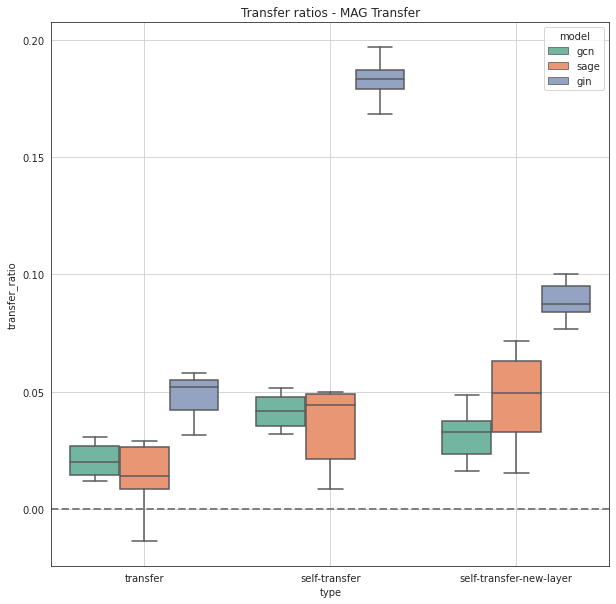

In [ ]:
plt.figure(figsize=(10, 10))

ax = sns.boxplot(data=transfer_ratios_df, x='type', y='transfer_ratio', hue='model', palette="Set2", showfliers = False)

ax.axhline(y=0, color='grey', lw=2, linestyle='--')

ax.grid(True)
plt.title('Transfer ratios - MAG Transfer');

plt.show()

#### Jumpstart

In [ ]:
# JUMPSTART
jumpstart_list = []

for i, model in enumerate(models):
    base_acc = experiment_results[frozenset({'base', model})]['accuracies']

    for type_ in types[1:]:
        transfer_acc = experiment_results[frozenset({model, type_})]['accuracies']
        jumpstart = [t[0]-b[0] for b, t in zip(base_acc, transfer_acc)]
        
        for js in jumpstart:
            js = {'model': model, 'type': type_, 'jumpstart': js}
            jumpstart_list.append(js)

jumpstart_df = pd.DataFrame.from_records(jumpstart_list)

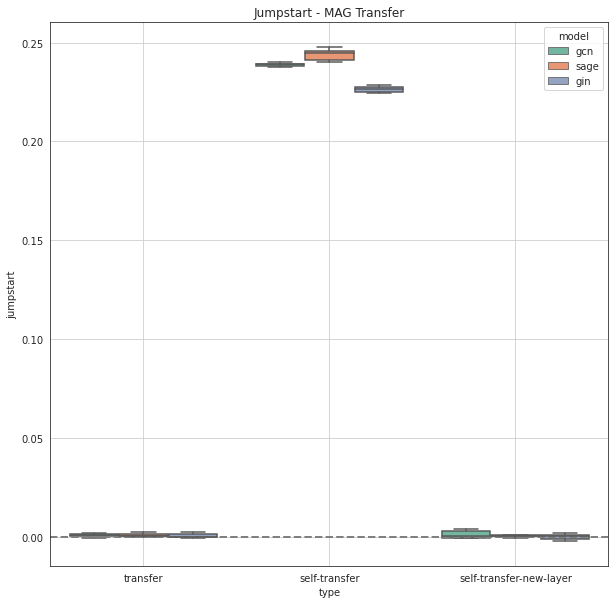

In [ ]:
plt.figure(figsize=(10, 10))

ax = sns.boxplot(data=jumpstart_df, x='type', y='jumpstart', hue='model', palette="Set2", showfliers = False)

ax.axhline(y=0, color='grey', lw=2, linestyle='--')

ax.grid(True)
plt.title('Jumpstart - MAG Transfer');

plt.show()

#### Asymptotic Performance

In [ ]:
# ASYPMTOTIC PREFORMANCE
asymptotic_perf_list = []

for i, model in enumerate(models):
    base_acc = experiment_results[frozenset({'base', model})]['accuracies']

    for type_ in types[1:]:
        transfer_acc = experiment_results[frozenset({model, type_})]['accuracies']
        asym_perf = [t[-1]-b[-1] for b, t in zip(base_acc, transfer_acc)]
        
        for ap in asym_perf:
            ap = {'model': model, 'type': type_, 'asymptotic_performance': ap}
            asymptotic_perf_list.append(ap)

asymptotic_perf_df = pd.DataFrame.from_records(asymptotic_perf_list)

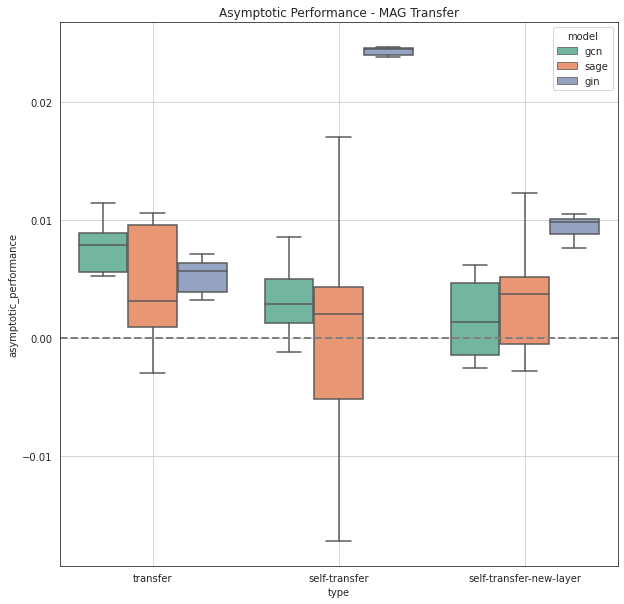

In [ ]:
plt.figure(figsize=(10, 10))

ax = sns.boxplot(data=asymptotic_perf_df, x='type', y='asymptotic_performance', hue='model', palette="Set2", showfliers = False)

ax.axhline(y=0, color='grey', lw=2, linestyle='--')

ax.grid(True)
plt.title('Asymptotic Performance - MAG Transfer');

plt.show()

#### Summary

In [ ]:
summary_list = []

for model in models:
    for type_ in types:
        accuracies = experiment_results[frozenset({model, type_})]['accuracies']
        
        for acc in accuracies:
            record = {'model': model, 'type': type_, 't_0_acc': acc[0], 't_n_acc': acc[-1], 'best_acc': acc.max()}
            summary_list.append(record)

summary_df = pd.DataFrame.from_records(summary_list)

In [ ]:
mean_ = (summary_df.groupby(['model', 'type']).mean() * 100).round(2)
std_ = (summary_df.groupby(['model', 'type']).std() * 100).round(2)

mean_str = pd.DataFrame({col: mean_[col].astype(str) for col in mean_.columns})
std_str = pd.DataFrame({col: std_[col].astype(str) for col in std_.columns})

str_df = mean_str + " ± " + std_str
str_df

t_0_acc       t_n_acc      best_acc
model type                                                             
gcn   base                      0.22 ± 0.04  29.29 ± 0.18   29.4 ± 0.17
      self-transfer            23.06 ± 2.29  29.59 ± 0.18  29.74 ± 0.15
      self-transfer-new-layer   0.33 ± 0.18  29.45 ± 0.25   29.6 ± 0.24
      transfer                   0.29 ± 0.1  30.05 ± 0.09  30.15 ± 0.13
gin   base                      0.39 ± 0.35  28.96 ± 0.12   29.06 ± 0.1
      self-transfer            22.96 ± 0.17  31.35 ± 0.06  31.49 ± 0.03
      self-transfer-new-layer   0.32 ± 0.15  29.88 ± 0.03   30.0 ± 0.07
      transfer                   0.3 ± 0.15  29.48 ± 0.08  29.61 ± 0.09
sage  base                      0.23 ± 0.03   29.91 ± 0.9  30.03 ± 0.88
      self-transfer            24.11 ± 1.84  30.05 ± 0.61  30.19 ± 0.59
      self-transfer-new-layer   0.28 ± 0.08  30.21 ± 0.93  30.37 ± 0.91
      transfer                   0.3 ± 0.09  30.63 ± 0.39  30.74 ± 0.36